<a href="https://colab.research.google.com/github/Roseyshi/Wine-Quality-Prediction/blob/main/Wine_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv("/content/winequalityN.csv")
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
data = data.dropna()
data.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [7]:
X = data.drop(['type', 'quality'], axis = 1)
y = data['quality']

In [8]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


In [9]:
y.value_counts()

quality
6    2820
5    2128
7    1074
4     214
8     192
3      30
9       5
Name: count, dtype: int64

The target variable has an imbalance in the classes and so this has to be solved before we proceed to avoid the majority class influencing the model selection.

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
from imblearn.over_sampling import SMOTE

unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

# Get the count of the minority class
minority_class_count = min(class_distribution.values())

# Ensure k_neighbors is less than the number of minority samples minus one
k_neighbors = min(5, minority_class_count - 1)

smote = SMOTE(sampling_strategy='auto', k_neighbors=k_neighbors, random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


{3: 23, 4: 151, 5: 1476, 6: 1992, 7: 747, 8: 131, 9: 4}


In [15]:
X_train_smote = pd.DataFrame(X_train_smote, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [16]:
from collections import Counter

Counter(y_train_smote)

Counter({6: 1992, 8: 1992, 7: 1992, 5: 1992, 4: 1992, 3: 1992, 9: 1992})

In [17]:
selectk = SelectKBest(score_func = f_classif, k = 5)
selectk.fit_transform(X_train_smote, y_train_smote)
selected_features_mask = selectk.get_support()
selected_features = X_train_smote.columns[selected_features_mask]

print("Selected Features:", selected_features.tolist())

Selected Features: ['volatile acidity', 'citric acid', 'chlorides', 'density', 'alcohol']


In [18]:
vt = VarianceThreshold(threshold = 0.5)
vt.fit_transform(X_train_smote)
selected_features_mask = vt.get_support()
selected_features = X_train_smote.columns[selected_features_mask]

variances = X_train_smote.var()


selected_features = X_train_smote.columns[selected_features_mask]
selected_variances = variances[selected_features_mask]

variances_df = pd.DataFrame({'Feature': selected_features, 'Variance': selected_variances})

print(variances_df.sort_values(by = 'Variance', ascending = False))


                                   Feature  Variance
free sulfur dioxide    free sulfur dioxide  1.862506
alcohol                            alcohol  1.215690
chlorides                        chlorides  1.156722
density                            density  0.986511
volatile acidity          volatile acidity  0.959261
total sulfur dioxide  total sulfur dioxide  0.938848
fixed acidity                fixed acidity  0.922643
pH                                      pH  0.848350
sulphates                        sulphates  0.839001
citric acid                    citric acid  0.837849
residual sugar              residual sugar  0.780619


In [19]:
number_of_estimators = range(25, 125, 25)
number_of_features = []
feature_importances = {}

for n in number_of_estimators:
  rfc = RandomForestClassifier(n_estimators = n, random_state = 42)
  rfc.fit(X_train_smote, y_train_smote)
  number_of_features.append(X_train_smote.shape[1] - np.sum(rfc.feature_importances_ == 0))

  feature_importances[n] = rfc.feature_importances_

  feature_importances_df = pd.DataFrame(feature_importances, index = X_train_smote.columns)
print(feature_importances_df)

for n in number_of_estimators:
    print(f"Top features for n_estimators = {n}:")
    print(feature_importances_df[n].sort_values(ascending=False))



                           25        50        75        100
fixed acidity         0.086602  0.089213  0.090736  0.090969
volatile acidity      0.089902  0.087912  0.087307  0.086866
citric acid           0.092554  0.090873  0.088969  0.088993
residual sugar        0.073917  0.074065  0.071338  0.071323
chlorides             0.114037  0.112847  0.111191  0.110921
free sulfur dioxide   0.099375  0.102397  0.104896  0.105941
total sulfur dioxide  0.094722  0.095677  0.095847  0.094420
density               0.083650  0.081028  0.080290  0.079300
pH                    0.085010  0.081335  0.081254  0.081254
sulphates             0.077589  0.078608  0.078863  0.079803
alcohol               0.102642  0.106045  0.109310  0.110209
Top features for n_estimators = 25:
chlorides               0.114037
alcohol                 0.102642
free sulfur dioxide     0.099375
total sulfur dioxide    0.094722
citric acid             0.092554
volatile acidity        0.089902
fixed acidity           0.086602
p

In [20]:
base_estimator = RandomForestClassifier(n_estimators = 50, random_state = 42)
rfe = RFE(base_estimator, n_features_to_select = 10)
rfe.fit(X_train_smote, y_train_smote)
ranking = rfe.ranking_

selected_features_mask = rfe.support_

selected_features = [X_train_smote.columns[i] for i in range(len(X_train_smote.columns)) if selected_features_mask[i]]

# Create a DataFrame to display features, their rankings, and whether they were selected
features_ranking_df = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Ranking': ranking,
    'Selected': selected_features_mask
})

print(features_ranking_df.sort_values(by='Ranking'))


                 Feature  Ranking  Selected
0          fixed acidity        1      True
1       volatile acidity        1      True
2            citric acid        1      True
4              chlorides        1      True
5    free sulfur dioxide        1      True
6   total sulfur dioxide        1      True
7                density        1      True
8                     pH        1      True
9              sulphates        1      True
10               alcohol        1      True
3         residual sugar        2     False


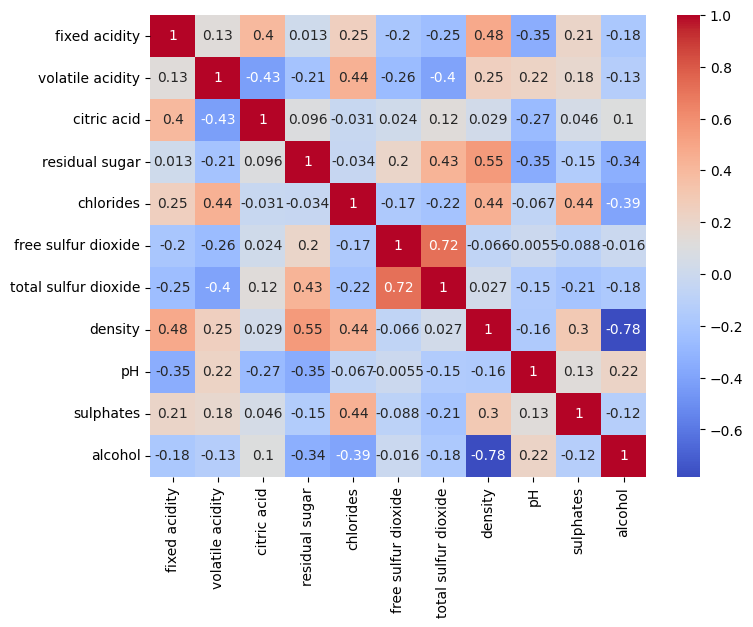

In [21]:
correlation_matrix = X_train_smote.corr()
plt.figure(figsize = (8,6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.show()

From the correlation heatmap above, **'density' and 'alcohol'** and **'free sulfur dioxide and total sulfur dioxide'** are highly correlated which would lead to multicollinearity in our model. We will therefore determine which of the features in the two pairs have a high correlation with quality. **'density' and 'fixed acidity'** and **'density' and residual sugar'** have a moderate correlation that we would further put to consideration on how they may affect the model.



In [22]:
correlation_quality = X_train_smote.corrwith(y_train_smote)
print(correlation_quality.sort_values(ascending = False))

alcohol                 0.566791
citric acid             0.227251
pH                      0.119290
free sulfur dioxide     0.067118
total sulfur dioxide    0.004017
residual sugar         -0.009949
sulphates              -0.066968
fixed acidity          -0.077511
volatile acidity       -0.329078
chlorides              -0.334067
density                -0.396139
dtype: float64


**'alcohol'** is highly correlated to quality compared to **'density'** despite having being close in magnitude. **'free sulfur dioxide'** has a higher correlation than **'total sulfur dioxide'**,  we will therefore keep **'free sulfur dioxide'**. Between **'density' and 'residual sugar'**, we will keep **'density'**. After the analysis, **'density', 'total sufur dioxide and 'residual sugar'** will be dropped as predictor variables.

In [23]:
from sklearn.feature_selection import RFECV


base_estimator = RandomForestClassifier(random_state=42)

rfe = RFECV(estimator=base_estimator, step=1, cv=5, scoring='accuracy')
rfe.fit(X_train_smote, y_train_smote)

selected_features = np.array(X_train_smote.columns)[rfe.support_]
feature_ranking = rfe.ranking_

feature_ranking_df = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Ranking': feature_ranking,
    'Selected': rfe.support_
})

# Sort the DataFrame by ranking
feature_ranking_df.sort_values(by='Ranking', inplace=True)

# Print the DataFrame
print("Feature Ranking (1 = most important):")
print(feature_ranking_df)

Feature Ranking (1 = most important):
                 Feature  Ranking  Selected
0          fixed acidity        1      True
1       volatile acidity        1      True
2            citric acid        1      True
3         residual sugar        1      True
4              chlorides        1      True
5    free sulfur dioxide        1      True
6   total sulfur dioxide        1      True
7                density        1      True
8                     pH        1      True
9              sulphates        1      True
10               alcohol        1      True


From the different feature selection tehcniques that have been used, **'Residual sugar','Total sulfur dioxide', 'Density'** and  **'Sulphates'** have not made to the top most important features that affect the quality of wine. The features will therefore be eliminated from our predictor variables list.